<h1>Оглавление<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Обзор-данных" data-toc-modified-id="Обзор-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Обзор данных</a></span></li><li><span><a href="#Разбиение-данных-на-выборки" data-toc-modified-id="Разбиение-данных-на-выборки-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Разбиение данных на выборки</a></span></li><li><span><a href="#Исследование-моделей" data-toc-modified-id="Исследование-моделей-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Исследование моделей</a></span></li><li><span><a href="#Проверка-модели-на-тестовой-выборке" data-toc-modified-id="Проверка-модели-на-тестовой-выборке-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Проверка модели на тестовой выборке</a></span></li><li><span><a href="#Проверка-модели-на-адекватность" data-toc-modified-id="Проверка-модели-на-адекватность-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Проверка модели на адекватность</a></span></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Вывод</a></span></li></ul></div>

# Рекомендация тарифов

**Иcходные данные**

Оператор мобильной связи выяснил: многие клиенты пользуются архивными тарифами. Они хотят построить систему, способную проанализировать поведение клиентов и предложить пользователям новый тариф: «Смарт» или «Ультра».

В нашем распоряжении данные о поведении клиентов, которые уже перешли на эти тарифы. 

**Цель исследования**

Построить модель для задачи классификации, которая выберет подходящий тариф.

**Ход исследования**
1. Обзор данных.
2. Подготовка выборок.
3. Исследование качества разных моделей.
4. Проверьте качество модели на тестовой выборке.
5. Проверка модели на вменяемость.

## Обзор данных

Выполним обзор данных из файла

In [1]:
#импортируем библиотеки
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier

In [2]:
pth1 = 'users_behavior.csv'
pth2 = '/datasets/users_behavior.csv'

if os.path.exists(pth1):
    df = pd.read_csv(pth1)
elif os.path.exists(pth2):
    df = pd.read_csv(pth2)
else:
    print('Что-то пошло не так =(')

In [3]:
print(df.info())
df.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   float64
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   float64
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 125.7 KB
None


,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0
5,58.0,344.56,21.0,15823.37,0
6,57.0,431.64,20.0,3738.90,1
7,15.0,132.40,6.0,21911.60,0
8,7.0,43.39,3.0,2538.67,1
9,90.0,665.41,38.0,17358.61,0


В таблице 3214 строк. Данные типов float64 и int64.

Согласно документации к данным, названия колонок отражают следующую информацию:
* `сalls` — количество звонков,
* `minutes` — суммарная длительность звонков в минутах,
* `messages` — количество sms-сообщений,
* `mb_used` — израсходованный интернет-трафик в Мб,
* `is_ultra` — каким тарифом пользовался в течение месяца («Ультра» — 1, «Смарт» — 0).

Нам необходимо обучить модель, способную по данным в колонках `calls`, `minutes`, `messages`, `mb_used` предсказать значение в колонке `is_ultra`.

Проверим сбалансированность данных по целевому признаку.

In [4]:
balance_target = df['is_ultra'].value_counts()
print(balance_target)

0    2229
1     985
Name: is_ultra, dtype: int64


In [5]:
print(f'Наблюдений с тарифом Смарт в данных {round(balance_target[0] / df["is_ultra"].shape[0], 2)}')
print(f'Наблюдений с тарифом Ультра в данных {round(balance_target[1] / df["is_ultra"].shape[0], 2)}')

Наблюдений с тарифом Смарт в данных 0.69
Наблюдений с тарифом Ультра в данных 0.31


Данных по тарифу Смарт примерно в 3 раза больше, чем по Ультра.

## Разбиение данных на выборки

Разабьем данные на на обучающую, валидационную и тестовую выборки.

In [6]:
#выделим набор данных и целивой признак 
features = df.drop(['is_ultra'], axis=1)
target = df['is_ultra']

In [7]:
#отделим 20% данных для тестовой выборки 
train_features, test_features, train_target, test_target = train_test_split(features, target, stratify=target, test_size=0.2, random_state=777)

In [8]:
#чтобы сохранить пропорцию 60/20/20 от получнеой тренировочной выборки отдели 25% в валидационную 
train_features, valid_features, train_target, valid_target = train_test_split(train_features, train_target, stratify=train_target, test_size=0.25, random_state=777)

In [9]:
#убедимся, что удалось сохранить пропорцию 60/20/20 
list = [train_features, valid_features, test_features]

for feat in list:
    share = round(len(feat) / len(features), 2)
    print(f'Доля значений от общей выборки составдяет {share}')

Доля значений от общей выборки составдяет 0.6
Доля значений от общей выборки составдяет 0.2
Доля значений от общей выборки составдяет 0.2


Успешно.

## Исследование моделей

Обучим и исследуем 3 модели на основе:
* дерева решений;
* случайного леса;
* логистической регрессии.

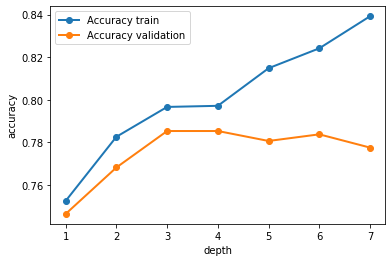

Accuracy наилучшей модели дерева решений на валидационной выборке: 0.7853810264385692
Глубина дерева решений: 3


In [10]:
#выберем лучшие параметры для модели дерева решений
tree_model = None
tree_model_result = 0
tree_depth = 0
tree_graf_train = []
tree_graf_valid = []
for depth in range(1, 8):
    model = DecisionTreeClassifier(max_depth=depth, random_state=777)
    model = model.fit(train_features, train_target)
    tree_graf_train.append(model.score(train_features, train_target))
    result = model.score(valid_features, valid_target)
    tree_graf_valid.append(result)
    if result > tree_model_result:
        tree_model_result = result
        tree_model = model
        tree_depth = depth
tree_graf_train = pd.Series(tree_graf_train)
tree_graf_valid = pd.Series(tree_graf_valid)
tree_graf_train.index = tree_graf_train.index + 1
tree_graf_valid.index = tree_graf_valid.index + 1
tree_graf_train.plot(linewidth = 2, marker = 'o')
tree_graf_valid.plot(linewidth = 2, marker = 'o')
plt.xlabel('depth')
plt.ylabel('accuracy')
plt.legend(['Accuracy train', 'Accuracy validation'])
plt.show()
print("Accuracy наилучшей модели дерева решений на валидационной выборке:", tree_model_result)
print("Глубина дерева решений:", tree_depth)

In [12]:
%%time

#выберем лучшие параметры для модели случайного леса
grid_model = RandomForestClassifier()
parametrs = {'n_estimators': range (3, 34, 5), 
             'max_depth': range (1, 8)}


# код ревьюера
grid = GridSearchCV(grid_model, parametrs)
# grid = GridSearchCV(grid_model, parametrs)

grid.fit(train_features, train_target)

forest_model = grid.best_estimator_
forest_model_result = grid.best_score_

print("Accuracy наилучшей модели случайного леса на валидационной выборке:", forest_model_result)
print("Число деревьев решений:", grid.best_params_['n_estimators'])
print("Максимальная глубина деревьев решений:", grid.best_params_['max_depth'])

Accuracy наилучшей модели случайного леса на валидационной выборке: 0.7997994751362627
Число деревьев решений: 18
Максимальная глубина деревьев решений: 7
CPU times: user 10.2 s, sys: 73.5 ms, total: 10.3 s
Wall time: 10.4 s


In [14]:
#выберем лучшие параметры для модели логистической регрессии
regression_model = None
regression_model_result = 0
regression_iter = 0
for iter in range(100, 1000, 100):
    model = LogisticRegression(random_state=777, max_iter=iter)
    model = model.fit(train_features, train_target)
    result = model.score(valid_features, valid_target)
    if result > regression_model_result:
        regression_model_result = result
        regression_model = model
        regression_iter = iter
print("Accuracy наилучшей модели логистической регрессии на валидационной выборке:", regression_model_result)
print("Максимальное число итераций:", regression_iter)

Accuracy наилучшей модели логистической регрессии на валидационной выборке: 0.7340590979782271
Максимальное число итераций: 100


Итак, на валидационной выборке лучший резултат имеет модель на основе случайного леса `forest_model`.

Необходимо выполнить прверки на тестовой выборке.

## Проверка модели на тестовой выборке

Поверим полученные модели на тестовой выборке.

In [15]:
test_result = forest_model.score(test_features, test_target)
print('Accuracy наилучшей модели на тестовой выборке:', test_result) 

Accuracy наилучшей модели на тестовой выборке: 0.8102643856920684


Модель случайного леса на тестовой выборке показала приемлимый результат.

## Проверка модели на адекватность

Сравним Accuracy нашей модели с фиктивной моделью.

In [16]:
dc_model = DummyClassifier(strategy="most_frequent", random_state=777)
dc_model.fit(train_features, train_target)
dc_result = dc_model.score(test_features, test_target)

if test_result > dc_result:
    print(f'Наша модель адекватна. Accuracy {round(test_result, 3)} против {round(dc_result, 3)} у фиктивной модели')
else:
    print(f'Наша модель не адекватна. Accuracy фиктивной модели {round(dc_result, 3)} против {round(test_result, 3)} нашей.')

Наша модель адекватна. Accuracy 0.81 против 0.694 у фиктивной модели


## Вывод

Мы обучили 3 модели, подобрав под них оптимальные параметры и выбрали лучшую модель, способную предложить пользователям подходящий тариф с точностью примерно 80.6%.

Модель обучена по алгоритму случайного леса и имеет слкдующие параметры: `max_depth=4`, `n_estimators=3`, `random_state=777`.

Проверка показала адекватность модели.